In [1]:
%load_ext autoreload
%autoreload 2

from pykitti.tracking import KittiTrackingLabels
from PyKitti2Dataset import PyKitti2
import numpy as np
import matplotlib.pyplot as plt
from hugeica import *
from Mine import *
from hugeica import Adam_Lie
import torch.nn as nn
from Crop import crop
import torch
import meshplot as mp
from sklearn.neighbors import NearestNeighbors

from AutoCalibration import *

basedir = "/home/ios/data3/kitti/tracking/training"
seq = "0000"

files 154


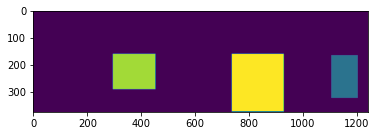

In [2]:
kitti = PyKitti2(basedir, seq, with_labels="mask")   
plt.imshow(kitti[0][4] * 200)

In [3]:
velo = kitti[0][0]
velo_labels = kitti[0][5] 
velo.shape, velo_labels.shape, velo_labels.max()

mp.plot(velo[:, :3], c=np.stack([velo_labels, velo_labels*0, velo_labels*0]).T* 20)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.0909996…

In [4]:
velo = kitti[0][1]

In [9]:
kitti.calib

CalibData(R_rect=array([[ 0.9999239 ,  0.00983776, -0.00744505,  0.        ],
       [-0.0098698 ,  0.9999421 , -0.00427846,  0.        ],
       [ 0.00740253,  0.00435161,  0.9999631 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), P_rect_00=array([[721.5377,   0.    , 609.5593,   0.    ],
       [  0.    , 721.5377, 172.854 ,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]]), P_rect_10=array([[ 721.5377,    0.    ,  609.5593, -387.5744],
       [   0.    ,  721.5377,  172.854 ,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]]), P_rect_20=array([[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
       [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
       [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]]), P_rect_30=array([[ 7.215377e+02,  0.000000e+00,  6.095593e+02, -3.395242e+02],
       [ 0.000000e+00,  7.215377e+02,  1.728540e+02,  2.199936e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,

In [3]:
kitti = PyKitti2(basedir, seq, with_labels="mask")   

files 154


In [8]:
kitti = PyKitti2(basedir, "0000", with_labels="box")#
kitti.calib.T_cam2_velo

files 154


array([[ 2.34773698e-04, -9.99944155e-01, -1.05634778e-02,
        -2.79681694e-03],
       [ 1.04494074e-02,  1.05653536e-02, -9.99889574e-01,
        -7.51087914e-02],
       [ 9.99945389e-01,  1.24365378e-04,  1.04513030e-02,
        -2.72132796e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [9]:
kitti = PyKitti2(basedir, "0001", with_labels="box")#
kitti.calib.T_cam2_velo

files 447


array([[ 2.34773698e-04, -9.99944155e-01, -1.05634778e-02,
        -2.79681694e-03],
       [ 1.04494074e-02,  1.05653536e-02, -9.99889574e-01,
        -7.51087914e-02],
       [ 9.99945389e-01,  1.24365378e-04,  1.04513030e-02,
        -2.72132796e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [102]:
import os
def read_calib_file(filepath):
    """Read in a calibration file and parse into a dictionary."""
    data = {}

    with open(filepath, 'r') as f:
        for line in f.readlines():
            try:
                key, value = line.split(':', 1)
            except:
                key, value = line.split(' ', 1)                        
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

calib_filepath = os.path.join(basedir, "calib", "0009" + ".txt")
filedata = read_calib_file(calib_filepath)
a = filedata['Tr_velo_cam']
a_ = filedata['P2']
a__ = filedata['R_rect']

In [109]:
calib_filepath = os.path.join(basedir, "calib", "0015" + ".txt") # 0-13, 14-17, 18-19, 20
filedata = read_calib_file(calib_filepath)
b = filedata['Tr_velo_cam']
b_ = filedata['P2']
b__ = filedata['R_rect']
np.allclose(a, b), np.allclose(a_, b_), np.allclose(a__, b__), np.linalg.norm(a.reshape((3,4))[:3, 3] - b.reshape((3,4))[:3, 3])

(False, False, False, 0.06546491149628689)

In [67]:
a = PyKitti2(basedir, "0019", with_labels="none")
a = a.calib.T_cam2_velo
b = PyKitti2(basedir, "0020", with_labels="none")
b = b.calib.T_cam2_velo
quat_diff(a[:3,:3], b[:3, :3])

files 1059
files 837


0.38280361715584177

In [13]:
[i for i in range(10,14)]

[10, 11, 12, 13]

files 154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


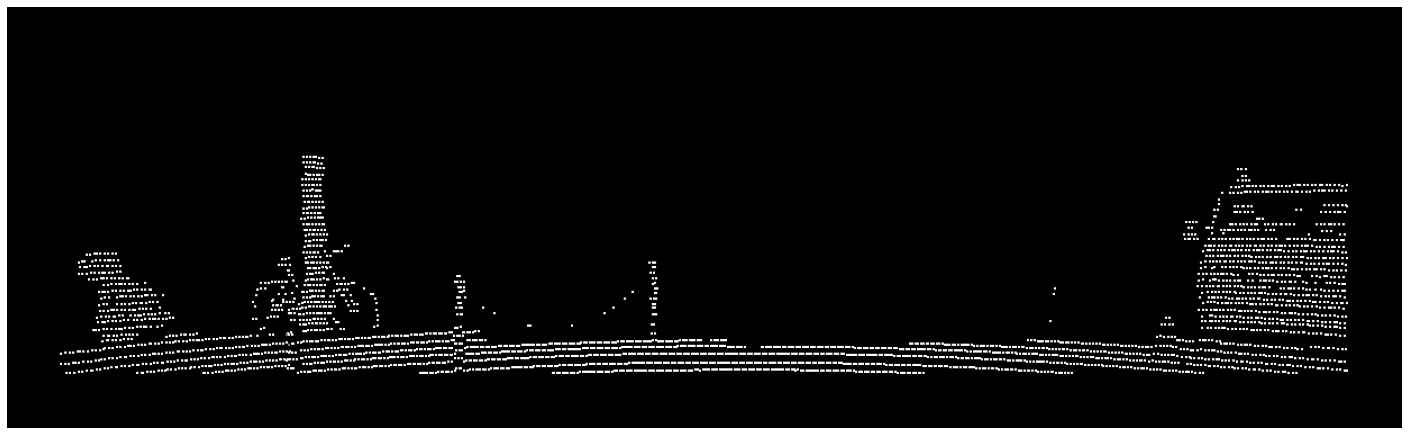

In [126]:
kitti = PyKitti2(basedir, seq, with_labels="none")  

ac = AutoCalibration(kitti.calib.T_cam2_velo, kitti.calib.P_rect_20, 
                     pc_batch=5000, mi_batch=20, 
                     patch_size=96, hidden_size=32,  
                     true_kittis=[kitti], max_z_true_kittis=30
                     )


idx = 90
point_cloud, cam2, image3, oxts = kitti[idx]

image, x, y, z, mask, max_x, max_y, max_z, valid_proj_pointcloud = ac.transform_points(point_cloud, cam2, clipping=False)

cam2_ = np.asarray(cam2).copy() * 0.

x, y, z = x.int().cpu().detach().numpy(), y.cpu().int().detach().numpy(), z.cpu().detach().numpy()
x = x[z < 10]
y = y[z < 10]
z = z[z < 10]
z = ( z- z.min())/( z.max()-  z.min()) * 255

from itertools import product
thick = 1
for i, (x_, y_) in enumerate(product(range(-thick, thick), range(-thick, thick))):
    cam2_[y+y_, x+x_] = np.array([z, z, z]).T

fig, ax = plt.subplots(figsize=(25, 25))

#img = Image.fromarray(cam2_).resize((cam2_.shape[1]//2, cam2_.shape[0]//2))
ax.axis("off")
ax.imshow(cam2_)

files 154

 Distortion t:  [0.07556248 0.17743579 0.05452022] r:  [2.89560433 0.72719715 2.41936093] 



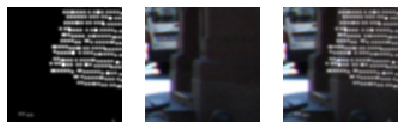

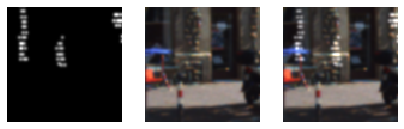

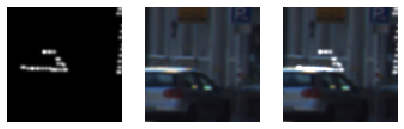

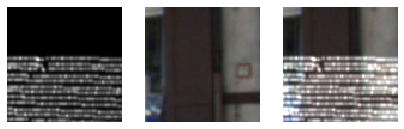

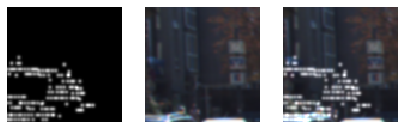

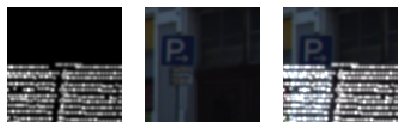

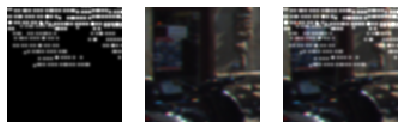

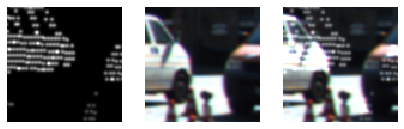

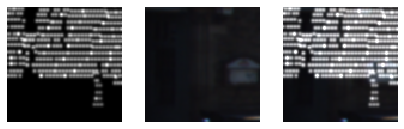

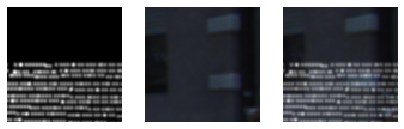

#   0: nll: 0.77/0.96, mi: -0.177/-0.408, acc: 52.5/55.0, eps: 0.23109, R=[2.84, 0.79, 2.48], t=0.21, Q_cos=3.84


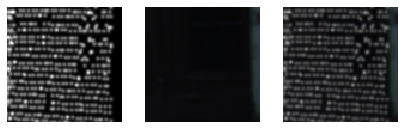

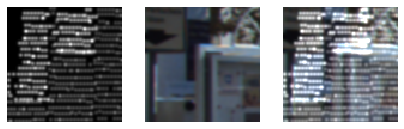

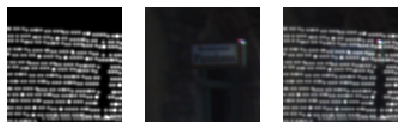

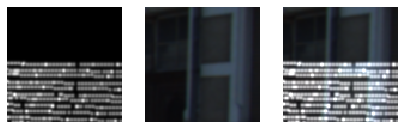

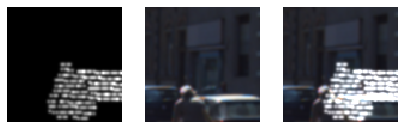

KeyboardInterrupt: 

In [115]:
kitti = PyKitti2(basedir, seq, with_labels="none") 

ac = AutoCalibration(kitti.calib.T_cam2_velo, kitti.calib.P_rect_20, 
                     pc_batch=5000, mi_batch=20, 
                     patch_size=96, hidden_size=32,  
                     true_kittis=[kitti], max_z_true_kittis=30
                     )

ac.to("cuda")
ac.load_state_dict(torch.load("checkpoints/mi_model_p96_small.pth.tar"))
ac.reset_calibration()

interval_t = np.random.uniform(0, 0.2, (3,))
interval_r = np.random.uniform(0, 3, (3,))
print("\n", "Distortion", "t: ", interval_t, "r: ",  interval_r, "\n")
ac.distort_calibration(interval_t, interval_r)

for iters, lr in [(500, 1e-3)]:

    #ac.load_state_dict(torch.load("checkpoints/checkpoint_best_mi.pth.tar"))
    ac.update_se_and_mine(lr_mi=lr, lr_R=lr, lr_T=10*lr)
    ac.best_mi = 0.
    r = ac.fit([kitti], iters=iters, log_interval=100, viz="jointn", 
               log_avg_window=1,
               n_test_batches=10, 
               valid_ratio=0.8, 
               grad_SE=True, 
               grad_R=True,
               grad_T=True)

log.append((r, interval_t, interval_r))
    

files 294

 Distortion t:  [0.18930662 0.12414912 0.14182946] r:  [1.32455767 1.69277721 0.68983218] 



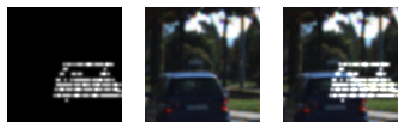

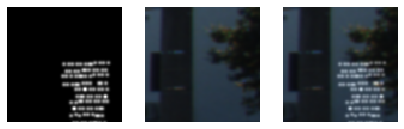

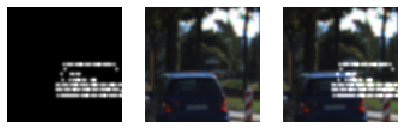

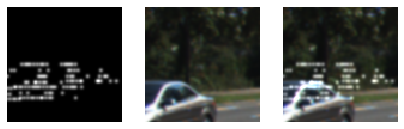

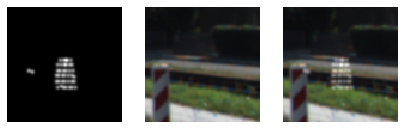

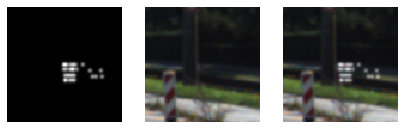

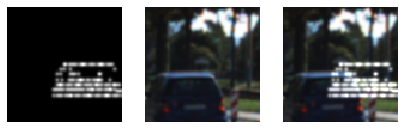

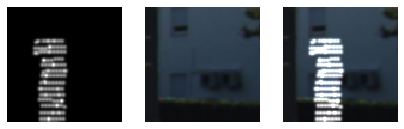

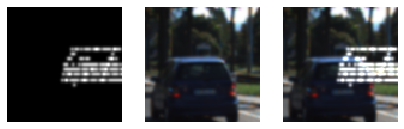

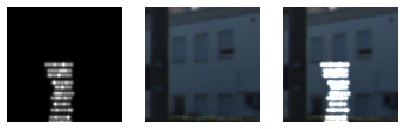

#   0: nll: 0.94/0.85, mi: -0.562/-0.201, acc: 42.5/57.2, eps: 0.27976, R=[1.27, 1.75, 0.75], t=0.27, Q_cos=2.28


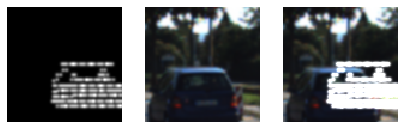

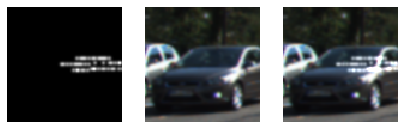

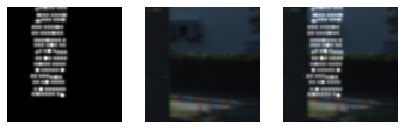

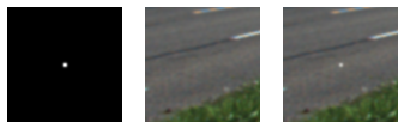

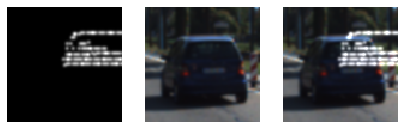

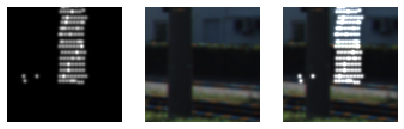

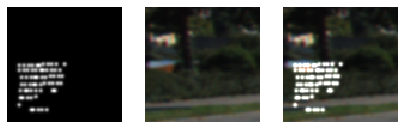

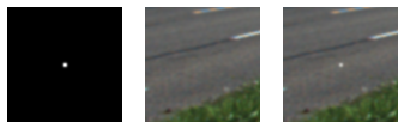

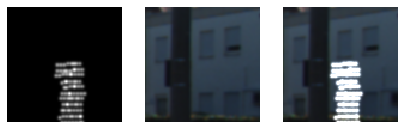

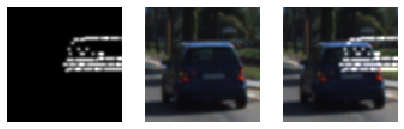

# 100: nll: 0.66/0.70, mi: -0.015/ 0.011, acc: 65.0/61.2, eps: 0.00167, R=[0.97, 1.34, 0.08], t=0.28, Q_cos=1.65


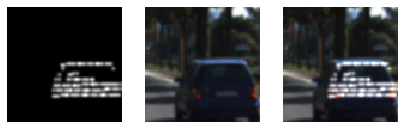

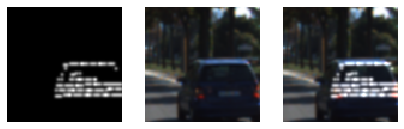

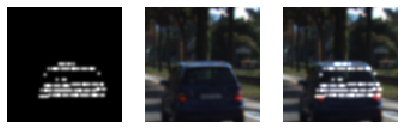

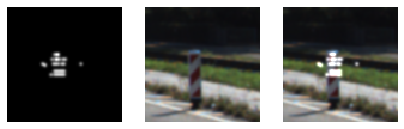

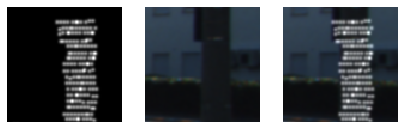

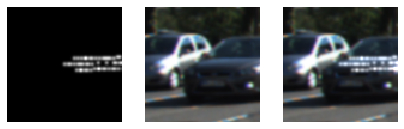

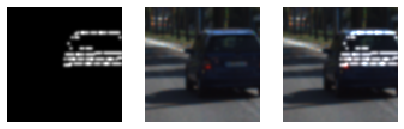

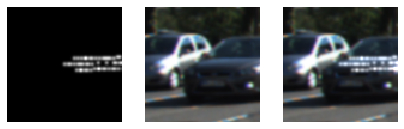

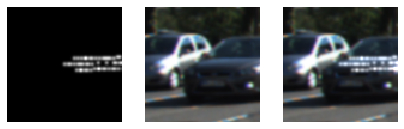

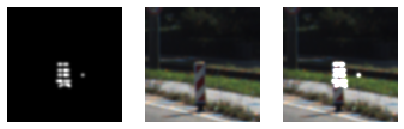

# 200: nll: 0.53/0.71, mi:  0.469/ 0.334, acc: 77.5/66.7, eps: 0.01791, R=[0.65, 0.26, -0.03], t=0.26, Q_cos=0.70
Saved checkpoint


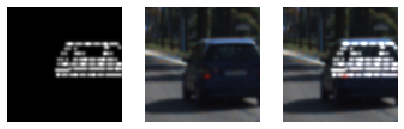

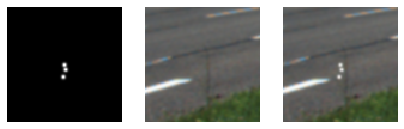

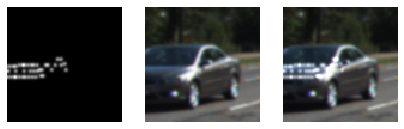

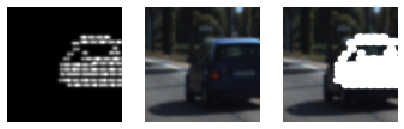

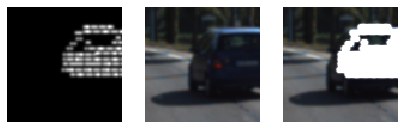

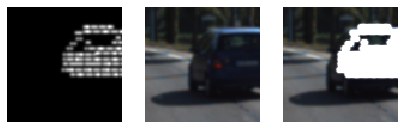

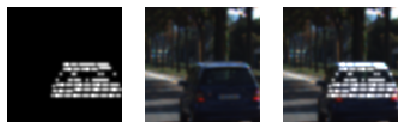

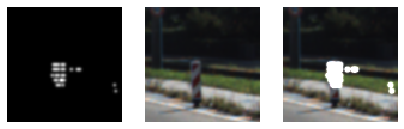

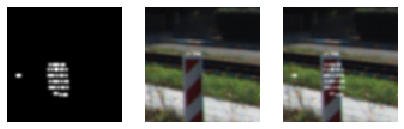

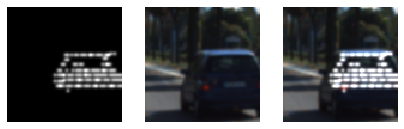

# 300: nll: 0.44/0.68, mi:  1.228/ 0.360, acc: 70.0/64.0, eps: 0.00230, R=[0.62, 0.16, -0.01], t=0.26, Q_cos=0.64
Saved checkpoint


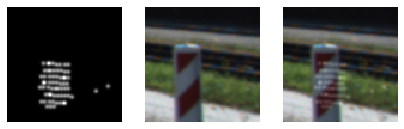

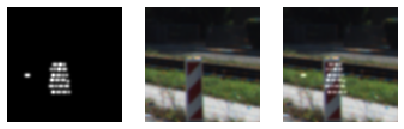

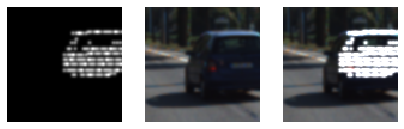

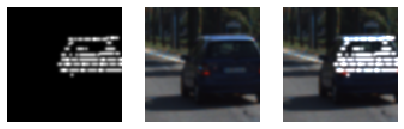

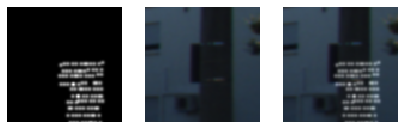

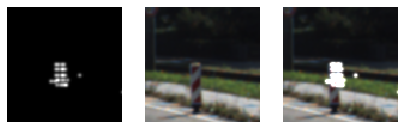

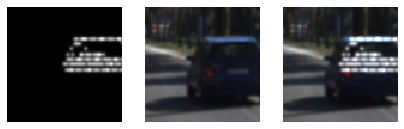

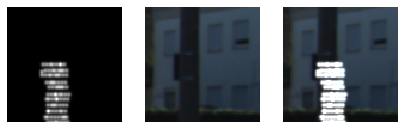

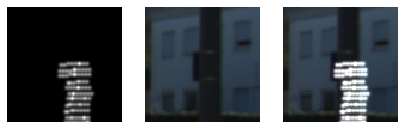

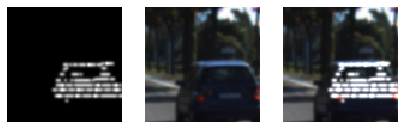

# 400: nll: 0.54/0.71, mi:  0.650/ 0.337, acc: 67.5/67.3, eps: 0.02186, R=[0.76, 0.33, 0.14], t=0.24, Q_cos=0.84


In [123]:
kitti = PyKitti2(basedir, "0010", with_labels="none") 

ac = AutoCalibration(kitti.calib.T_cam2_velo, kitti.calib.P_rect_20, 
                     pc_batch=5000, mi_batch=20, 
                     patch_size=96, hidden_size=32,  
                     true_kittis=[kitti], max_z_true_kittis=30
                     )

ac.to("cuda")
ac.load_state_dict(torch.load("checkpoints/mi_model_p96_small.pth.tar"))
ac.reset_calibration()

interval_t = np.random.uniform(0, 0.2, (3,))
interval_r = np.random.uniform(0, 3, (3,))
print("\n", "Distortion", "t: ", interval_t, "r: ",  interval_r, "\n")
ac.distort_calibration(interval_t, interval_r)

for iters, lr in [(500, 1e-3)]:

    #ac.load_state_dict(torch.load("checkpoints/checkpoint_best_mi.pth.tar"))
    ac.update_se_and_mine(lr_mi=lr, lr_R=lr, lr_T=10*lr)
    ac.best_mi = 0.
    r = ac.fit([kitti], iters=iters, log_interval=100, viz="jointn", 
               log_avg_window=1,
               n_test_batches=10, 
               valid_ratio=0.2, 
               grad_SE=True, 
               grad_R=True,
               grad_T=True)

log.append((r, interval_t, interval_r))
    

In [100]:
from Movie import *
import cv2

kitti = PyKitti2(basedir, "0014", with_labels="none")  

ac = AutoCalibration(kitti.calib.T_cam2_velo, kitti.calib.P_rect_20, 
                     max_z=30, 
                     pc_batch=5000, mi_batch=20, 
                     patch_size=96, hidden_size=32,  
                     true_kittis=[kitti], max_z_true_kittis=30
                     )

#ac.clip_floor_3d = -1 # 3d z-coord
#ac.clip_floor_2d = 100 # image pixels

frames = [] # for storing the generated images
for i in range(0, len(kitti)):
    point_cloud, cam2, image3, oxts = kitti[i]
    
    image, x, y, z, mask, max_x, max_y, max_z, valid_proj_pointcloud = ac.transform_points(point_cloud, cam2, clipping=True)

    cam2_ = np.asarray(cam2).copy() * 0.

    x, y, z = x.int().cpu().detach().numpy(), y.cpu().int().detach().numpy(), z.cpu().detach().numpy()
    #x = x[z < 50]
    #y = y[z < 50]
    #z = z[z < 50]
    z = ( z- z.min())/( z.max()-  z.min()) * 255

    cam2_[y, x] = np.array([z, z, z]).T
    
    frames.append(cam2_)
    


files 106


In [101]:
images_to_video([f.astype(np.uint8) for f in frames], video_name = 'video_14_b30.avi')

In [94]:
np.unique([0,1, 1])

array([0, 1])